In [1]:
import numpy as np
import pandas as pd 

import os

import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

%matplotlib inline

In [2]:
import splitfolders
splitfolders.ratio('dataset_balanced', output='splitdata', seed=1337, ratio=(0.7, 0.1, 0.2))

In [3]:
data = 'dataset'

In [4]:
all_items,dirs,files = next(os.walk(data))
image_in_classes = []
for i in range(len(dirs)):
    no_of_images =len(os.listdir(os.path.join(data,dirs[i])))
    image_in_classes.append(no_of_images)
df_data = {'class': dirs,'counts': image_in_classes}
classes_df = pd.DataFrame(df_data)

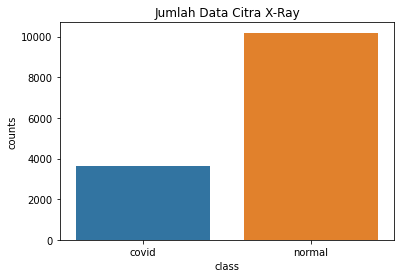

In [5]:
#data imbalance

sns.barplot(x = 'class', y = 'counts',data = classes_df)
plt.title('Jumlah Data Citra X-Ray')
plt.show()

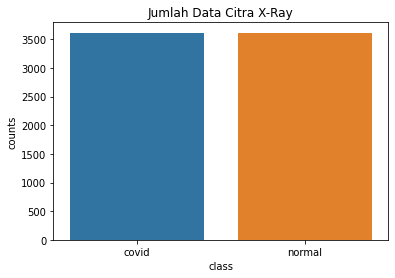

In [6]:
#data sudah balance

databalanced = 'dataset_balanced'
all_items,dirs,files = next(os.walk(databalanced))
image_in_classes = []
for i in range(len(dirs)):
    no_of_images =len(os.listdir(os.path.join(databalanced,dirs[i])))
    image_in_classes.append(no_of_images)
df_data = {'class': dirs,'counts': image_in_classes}
classes_df = pd.DataFrame(df_data)

#sebelum data imbalance
sns.barplot(x = 'class', y = 'counts',data = classes_df)
plt.title('Jumlah Data Citra X-Ray')
plt.show()

In [7]:
test_dir = "splitdata/test"
train_dir = "splitdata/train"
val_dir = "splitdata/val"

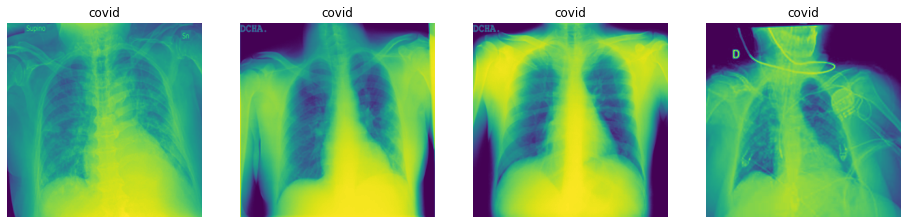

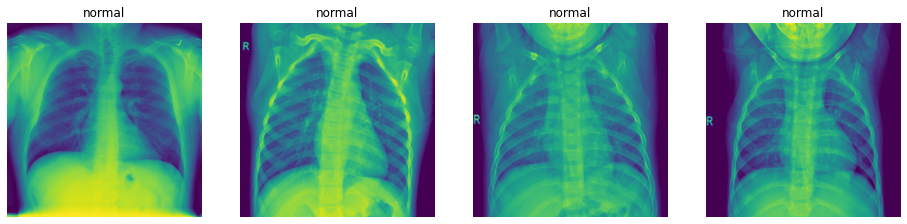

In [8]:
#Menampilkan sample sebagian gambar dari kelas yang berbeda dengan ukuran 2 baris x 4 kolom

import matplotlib.pyplot as plt
import matplotlib.image as mping

file_train_benign=os.path.join("splitdata/train/covid")
file_train_malignant=os.path.join("splitdata/train/normal")

benign_image = os.listdir(file_train_benign)
malignant_image = os.listdir(file_train_malignant)

fname1 = [os.path.join(file_train_benign,fname)
        for fname in benign_image[:4]]

fname2 = [os.path.join(file_train_malignant,fname)
        for fname in malignant_image[:4]]

ncolu = 4
nrow = 2
fig = plt.gcf()
fig.set_size_inches(ncolu*4,nrow*4)
for i,fname in enumerate(fname1):
    sp = plt.subplot(2,4,i+1)
    sp.axis('off')
    img = mping.imread(fname)
    plt.title('covid')
    plt.imshow(img)
plt.show()

ncolu = 4
nrow = 2
fig = plt.gcf()
fig.set_size_inches(ncolu*4,nrow*4)
for i,fname in enumerate(fname2):
    sp = plt.subplot(2,4,i+1)
    sp.axis('off')
    img = mping.imread(fname)
    plt.title('normal')
    plt.imshow(img)
    
plt.show()

In [9]:
image_shape = (150,150,3)
image_gen = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.10,
                               height_shift_range=0.10,
                               rescale=1/255,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest')

In [10]:
model = Sequential()

model.add(Conv2D(filters=128, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation = 'softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9248)              0

In [11]:
#early_stop = EarlyStopping(monitor='val_loss',patience=2, verbose = 1)

best_model_path = 'modelcnn.h5'
checkpoint_callback = ModelCheckpoint(best_model_path, monitor='val_accuracy', save_best_only=True, verbose=1)
batch_size = 64

In [12]:
train_image_gen = image_gen.flow_from_directory(train_dir,
                                               target_size=(150,150),
                                               batch_size=batch_size,
                                               class_mode='categorical')

Found 5062 images belonging to 2 classes.


In [13]:
val_image_gen = image_gen.flow_from_directory(val_dir,
                                               target_size=(150,150),
                                               batch_size=batch_size,
                                               class_mode='categorical',shuffle=False)

Found 722 images belonging to 2 classes.


In [14]:
test_image_gen = image_gen.flow_from_directory(test_dir,
                                               target_size=(150,150),
                                               batch_size=batch_size,
                                               class_mode='categorical',shuffle=False)

Found 1448 images belonging to 2 classes.


In [15]:
print(train_image_gen.class_indices)
print(val_image_gen.class_indices)

{'covid': 0, 'normal': 1}
{'covid': 0, 'normal': 1}


In [16]:
results = model.fit(train_image_gen,epochs=100,
                              validation_data=val_image_gen,
                             callbacks=[checkpoint_callback])

Epoch 1/100
80/80 [==============================] - 102s 911ms/step - loss: 0.6558 - accuracy: 0.6197 - val_loss: 0.5900 - val_accuracy: 0.6898

Epoch 00001: val_accuracy improved from -inf to 0.68975, saving model to modelcnn.h5
Epoch 2/100
80/80 [==============================] - 36s 448ms/step - loss: 0.5886 - accuracy: 0.6989 - val_loss: 0.5453 - val_accuracy: 0.7327

Epoch 00002: val_accuracy improved from 0.68975 to 0.73269, saving model to modelcnn.h5
Epoch 3/100
80/80 [==============================] - 37s 465ms/step - loss: 0.5436 - accuracy: 0.7272 - val_loss: 0.5063 - val_accuracy: 0.7424

Epoch 00003: val_accuracy improved from 0.73269 to 0.74238, saving model to modelcnn.h5
Epoch 4/100
80/80 [==============================] - 38s 471ms/step - loss: 0.5236 - accuracy: 0.7388 - val_loss: 0.5066 - val_accuracy: 0.7465

Epoch 00004: val_accuracy improved from 0.74238 to 0.74654, saving model to modelcnn.h5
Epoch 5/100
80/80 [==============================] - 38s 470ms/step - 

80/80 [==============================] - 38s 473ms/step - loss: 0.1722 - accuracy: 0.9324 - val_loss: 0.1319 - val_accuracy: 0.9488

Epoch 00079: val_accuracy did not improve from 0.95706
Epoch 80/100
80/80 [==============================] - 39s 480ms/step - loss: 0.1717 - accuracy: 0.9338 - val_loss: 0.1331 - val_accuracy: 0.9460

Epoch 00080: val_accuracy did not improve from 0.95706
Epoch 81/100
80/80 [==============================] - 38s 475ms/step - loss: 0.1707 - accuracy: 0.9354 - val_loss: 0.1693 - val_accuracy: 0.9252

Epoch 00081: val_accuracy did not improve from 0.95706
Epoch 82/100
80/80 [==============================] - 38s 475ms/step - loss: 0.1810 - accuracy: 0.9309 - val_loss: 0.1181 - val_accuracy: 0.9391

Epoch 00082: val_accuracy did not improve from 0.95706
Epoch 83/100
80/80 [==============================] - 39s 480ms/step - loss: 0.1888 - accuracy: 0.9257 - val_loss: 0.1572 - val_accuracy: 0.9377

Epoch 00083: val_accuracy did not improve from 0.95706
Epoch 84

In [17]:
loss_df = pd.DataFrame(model.history.history)
loss_df

,loss,accuracy,val_loss,val_accuracy
0,0.655769,0.619716,0.589951,0.689751
1,0.588620,0.698933,0.545296,0.732687
2,0.543647,0.727183,0.506345,0.742382
3,0.523619,0.738838,0.506574,0.746537
4,0.511885,0.743777,0.486032,0.774238
...,...,...,...,...
95,0.154535,0.937179,0.174066,0.934903
96,0.166156,0.938167,0.113252,0.948753
97,0.152693,0.941525,0.138961,0.948753
98,0.157275,0.938957,0.127557,0.951524


<AxesSubplot:>

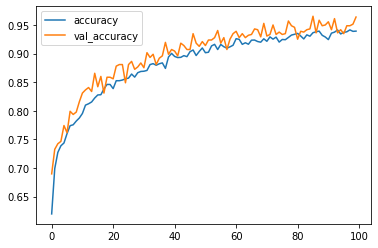

In [18]:
loss_df[['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

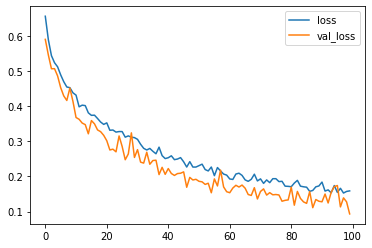

In [19]:
loss_df[['loss', 'val_loss']].plot()

In [20]:
#we can test our model on testing data

model.evaluate(test_image_gen)

23/23 [==============================] - 20s 868ms/step - loss: 0.1389 - accuracy: 0.9475


[0.13894739747047424, 0.9475138187408447]

In [21]:
predictions = np.argmax(model.predict(test_image_gen), axis = -1)
predictions

array([0, 1, 0, ..., 1, 1, 1], dtype=int64)

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       724
           1       0.96      0.94      0.95       724

    accuracy                           0.95      1448
   macro avg       0.95      0.95      0.95      1448
weighted avg       0.95      0.95      0.95      1448



Confusion matrix, without normalization
[[696  28]
 [ 47 677]]


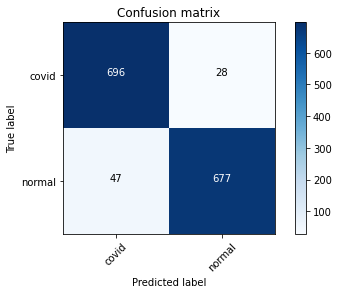

In [23]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix=confusion_matrix(test_image_gen.classes,predictions)
plot_confusion_matrix(cnf_matrix, classes=test_image_gen.class_indices)

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mping

file_test_rock = os.path.join('splitdata/test/covid')
file_test_paper = os.path.join('splitdata/test/normal')

rock_image = os.listdir(file_test_rock)
paper_image = os.listdir(file_test_paper)

fRock = [os.path.join(file_test_rock,fname)
        for fname in rock_image[0:5]]

fPaper = [os.path.join(file_test_paper,fname)
        for fname in paper_image[0:5]]

xz = 0

In [26]:
from PIL import Image
import time
def preprocess(img,input_size):
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    img_arr = (np.array(nimg))/255
    return img_arr

def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)

labels = ['Covid', 'Normal']
labels2 = ['Covid', 'Normal']
value = [fRock, fPaper]
input_size = (150, 150)

title = []
prediksi = []
waktu = []
akurasi = []

for x in list(range(len(labels))):
  for gambar in value[x]:
    title.append(labels2[x])
    im = Image.open(gambar)
    X = preprocess(im, input_size)
    X = reshape([X])
    start = time.time()
    Y = model.predict(X)
    end = time.time()
    times = end-start
    prediksi.append(labels[np.argmax(Y)])
    waktu.append(times)
    akurasi.append(np.max(Y))

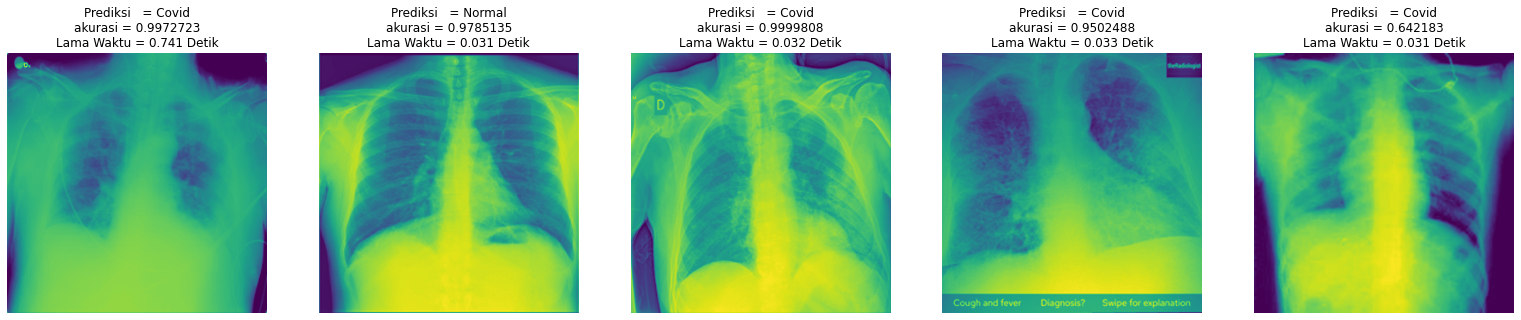

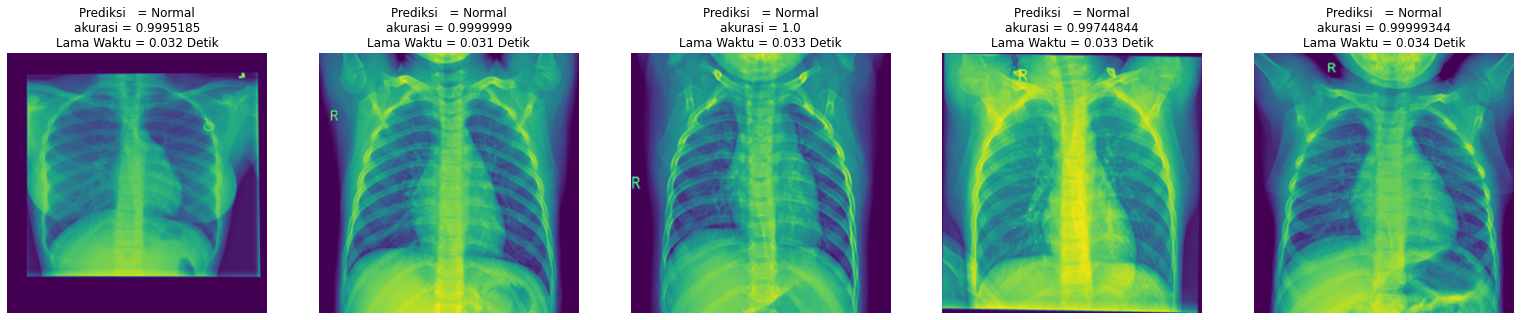

In [27]:
ncolu = 3
nrow = 5
fig = plt.gcf()
fig.set_size_inches(ncolu*9,nrow*4)
for i,fname in enumerate(fRock):
    sp = plt.subplot(3,5,i+1)
    sp.axis('off')
    img = mping.imread(fname)
    judul = 'Prediksi   = ' + prediksi[xz] + '\nakurasi = '+ str(akurasi[xz]) + '\nLama Waktu = ' + '{:.3f}'.format(waktu[xz]) + ' Detik'
    xz = xz+1
    plt.title(judul)
    plt.imshow(img)
plt.show()

ncolu = 3
nrow = 5
fig = plt.gcf()
fig.set_size_inches(ncolu*9,nrow*4)
for i,fname in enumerate(fPaper):
    sp = plt.subplot(3,5,i+1)
    sp.axis('off')
    img = mping.imread(fname)
    judul = 'Prediksi   = ' + prediksi[xz] + '\nakurasi = '+ str(akurasi[xz]) + '\nLama Waktu = ' + '{:.3f}'.format(waktu[xz]) + ' Detik'
    xz = xz+1
    plt.title(judul)
    plt.imshow(img)
plt.show()